# ⚛️ H₂ VQE — Ansatz Comparison (Noiseless)

This notebook compares **variational ansatz choices** for the H₂ molecule using a
clear **two-part workflow**:

---

# 🧩 **Part A — Educational Ansatz Comparison**  
A lightweight, from-scratch demonstration that:

- Uses the simple ansatz functions from `vqe_utils.ANSATZES`  
- Builds a manual cost function for each ansatz  
- Runs small VQE loops with the Adam optimizer  
- Plots convergence  
- Draws each circuit visually  

This section illustrates **model expressivity**, **circuit structure**, and how
parameterization affects convergence.

---

# 🟦 **Part B — Production-Grade Ansatz Comparison**  
Uses your high-level API:

```python
from vqe.core import run_vqe_ansatz_comparison
```

which automatically handles:

- device creation  
- caching  
- parameter initialization  
- plotting (via unified utilities)  

This is the version used in your actual research workflows.

---

Both sections simulate:

- **H₂** in the **STO-3G** basis  
- **Noiseless** (`default.qubit`)  
- **Adam** optimizer  


# 🧩 Part A — Educational Ansatz Comparison

In this section, we manually:

1. Build a VQE cost function for each ansatz  
2. Run the optimisation loop  
3. Plot convergence  
4. Draw each circuit  

This provides intuition about **circuit depth**, **expressivity**, and **training behavior**.

In [1]:
# Core scientific stack
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import json, time, os, sys

# Import utilities from package
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from vqe.vqe_utils import (
    ANSATZES,
    get_optimizer,
    init_params,
    make_run_config_dict,
    run_signature,
    find_existing_run,
    save_run_record,
    ensure_dirs,
    IMG_DIR,
)

ensure_dirs()

seed = 0
np.random.seed(seed)

# H₂ molecule setup
symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.7414],
])

basis = "STO-3G"

hamiltonian, qubits = qchem.molecular_hamiltonian(
    symbols, coordinates, charge=0, basis=basis
)

num_wires = qubits
dev = qml.device("default.qubit", wires=num_wires)

print("Number of wires:", num_wires)

Number of wires: 4


## 🎛 Step 1 — Build a cost function for each ansatz

In [2]:
def create_cost(ansatz_fn):
    """Wraps an ansatz into a VQE cost function."""
    @qml.qnode(dev)
    def circuit(params):
        ansatz_fn(params, wires=[0, 1])
        return qml.expval(hamiltonian)
    return circuit


def run_ansatz_with_cache(ansatz_name, stepsize, max_iters):
    """Runs and caches VQE for a given ansatz."""
    ansatz_fn = ANSATZES[ansatz_name]
    cost = create_cost(ansatz_fn)

    optimizer_name = "Adam"
    ansatz_desc = f"{ansatz_name} (educational)"

    cfg = make_run_config_dict(
        symbols=symbols,
        coordinates=coordinates,
        basis=basis,
        ansatz_desc=ansatz_desc,
        optimizer_name=optimizer_name,
        stepsize=stepsize,
        max_iterations=max_iters,
        seed=seed,
    )

    sig = run_signature(cfg)
    fname = f"H2_Ansatz_{ansatz_name}_s{seed}__{sig}"
    existing = find_existing_run(sig)

    # Load from cache if available
    if existing:
        with open(existing) as f:
            rec = json.load(f)
        print(f"[reuse] {ansatz_name}: loaded {existing}")
        energy_traj = rec["energies"]
        params = np.array(rec["final_params"], requires_grad=True)
        final_energy = float(energy_traj[-1])
        return final_energy, energy_traj, params

    # Otherwise run fresh VQE
    params = init_params(ansatz_name, num_wires=2, scale=0.05)
    opt = get_optimizer("Adam", stepsize)

    energy_traj = []
    for _ in range(max_iters):
        params = opt.step(cost, params)
        energy_traj.append(float(cost(params)))

    final_energy = energy_traj[-1]

    # Cache results
    record = {
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "molecule": "H2",
        "symbols": symbols,
        "geometry": coordinates.tolist(),
        "basis": basis,
        "ansatz": ansatz_desc,
        "optimizer": {
            "name": optimizer_name,
            "stepsize": stepsize,
            "iterations_planned": max_iters,
        },
        "seed": seed,
        "energies": energy_traj,
        "final_params": [float(x) for x in params],
        "config_hash": sig,
    }

    saved = save_run_record(fname, record)
    print(f"[saved] {ansatz_name}: {saved}")

    return final_energy, energy_traj, params

## 🚀 Step 2 — Run VQE for each educational ansatz

In [3]:
max_iters = 80
stepsize = 0.2
results_A = {}

for name in ANSATZES:
    print(f"\nRunning educational VQE with ansatz: {name}")
    E, traj, params = run_ansatz_with_cache(name, stepsize, max_iters)
    results_A[name] = {"final_energy": E, "trajectory": traj, "params": params}
    print(f"Final energy ({name}) = {E:.8f} Ha")


Running educational VQE with ansatz: TwoQubit-RY-CNOT
[reuse] TwoQubit-RY-CNOT: loaded /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H2_Ansatz_TwoQubit-RY-CNOT_s0__e59fcc57faaf.json
Final energy (TwoQubit-RY-CNOT) = -0.88776916 Ha

Running educational VQE with ansatz: RY-CZ
[reuse] RY-CZ: loaded /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H2_Ansatz_RY-CZ_s0__f8252e51d73e.json
Final energy (RY-CZ) = -0.88770518 Ha

Running educational VQE with ansatz: Minimal
[reuse] Minimal: loaded /workspaces/Variational_Quantum_Eigensolver/data/vqe/results/H2_Ansatz_Minimal_s0__9930c767c4cb.json
Final energy (Minimal) = -0.88809799 Ha


## 📉 Step 3 — Convergence Plots (Educational)

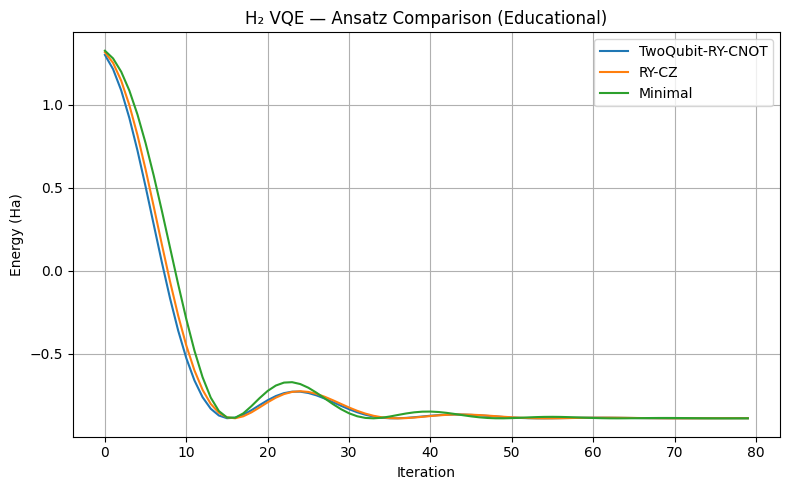

In [4]:
plt.figure(figsize=(8, 5))

for name, data in results_A.items():
    plt.plot(data["trajectory"], label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₂ VQE — Ansatz Comparison (Educational)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig(f"{IMG_DIR}/H2_Ansatz_Comparison_Educational.png", dpi=300)
plt.show()

## 🔎 Step 4 — Draw Each Circuit


TwoQubit-RY-CNOT circuit:


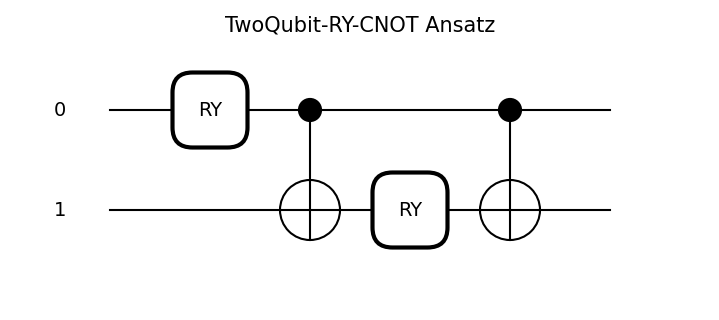


RY-CZ circuit:


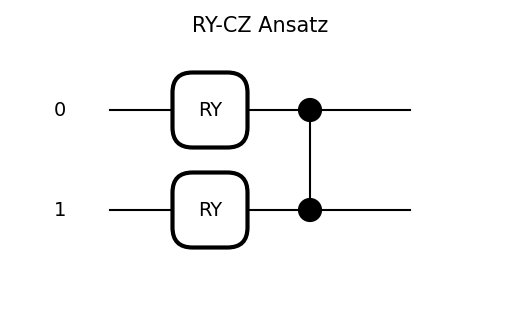


Minimal circuit:


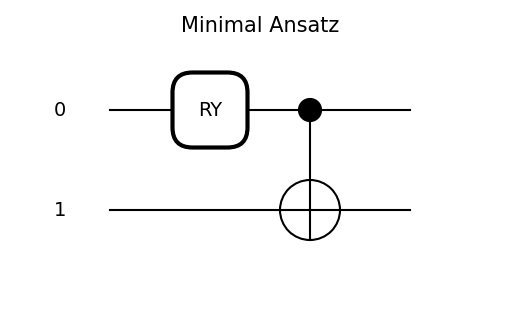

In [5]:
for name, ansatz_fn in ANSATZES.items():
    params = results_A[name]["params"]
    print(f"\n{name} circuit:")
    fig, ax = qml.draw_mpl(ansatz_fn)(params, wires=[0, 1])
    fig.suptitle(f"{name} Ansatz", fontsize=15)
    fig.savefig(f"{IMG_DIR}/H2_{name}_Circuit.png", dpi=300, bbox_inches="tight")
    plt.show()

# 🟦 Part B — Production-Level Ansatz Comparison

This section uses:

```python
run_vqe_ansatz_comparison(...)
```

which provides:

- Unified device/ansatz setup  
- Cached results  
- Automatic plotting via your `vqe_qpe_common` utilities  
- A clean, research-ready output  

This is the *real* workflow for comparing ansatz performance in your package.


🔹 Running ansatz: RY-CZ

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__RY-CZ__Adam__VQE__noiseless__s0__0311bcaea86c.json

🔹 Running ansatz: Minimal

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__Minimal__Adam__VQE__noiseless__s0__bf0f67d31a3b.json

🔹 Running ansatz: TwoQubit-RY-CNOT

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2__TwoQubit-RY-CNOT__Adam__VQE__noiseless__s0__8b4cd16e4af4.json
📁 Saved → /workspaces/Variational_Quantum_Eigensolver/images/vqe/VQE_Ansatz_Comparison_H2_Adam.png


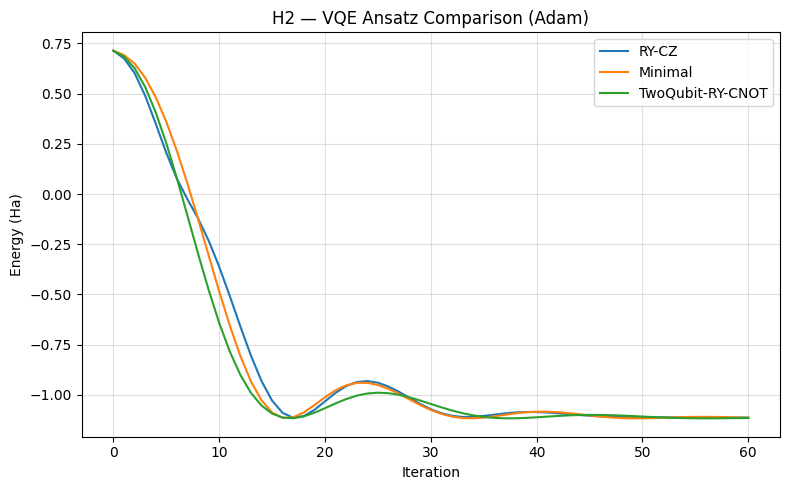


✅ Ansatz comparison complete for H2 (Adam)


{'energies': {'RY-CZ': [0.7135804090124337,
   0.675481393269311,
   0.6027354479156849,
   0.48973426828828676,
   0.3504547482526133,
   0.2051835288498035,
   0.07624250623274426,
   -0.026113635887851518,
   -0.12129307887739676,
   -0.23164053829756348,
   -0.3619605754511402,
   -0.5076089274204888,
   -0.6591965474864867,
   -0.804629235569808,
   -0.931289739607728,
   -1.0285112454292582,
   -1.0897491926464782,
   -1.1139193063503399,
   -1.1056566274046444,
   -1.074349662566803,
   -1.031886636030942,
   -0.9896719394765322,
   -0.9562026064892627,
   -0.936165059788292,
   -0.9308653489765755,
   -0.9391836863307662,
   -0.9584608824902022,
   -0.9851558075181949,
   -1.0153471863641719,
   -1.0451844088400253,
   -1.071331102263572,
   -1.0913712884220448,
   -1.104099567569693,
   -1.1096090630096158,
   -1.109127423170653,
   -1.1046253856268833,
   -1.098306796470992,
   -1.0921344590648328,
   -1.0875171968403319,
   -1.085199170917537,
   -1.0853125494210767,
   -1.0

In [6]:
from vqe.core import run_vqe_ansatz_comparison

results_B = run_vqe_ansatz_comparison(
    molecule="H2",
    optimizer_name="Adam",
    ansatzes=["RY-CZ", "Minimal", "TwoQubit-RY-CNOT"],
    steps=60,
    stepsize=0.2,
    noisy=False,
    force=False,
)

results_B